In [1]:
import requests
import json
import time
from kafka import KafkaProducer
from pymongo import MongoClient

# Function to retrieve the API key from a file
def get_api_key(file_path):
    try:
        with open(file_path, "r") as file:
            return file.read().strip()
    except FileNotFoundError:
        print(f"Error: API key file not found at {file_path}")
        exit(1)
    except Exception as e:
        print(f"Error reading API key file: {e}")
        exit(1)

# Your YouTube API key
API_KEY_FILE = r"C:\API\cr7_yt.txt"
API_KEY = get_api_key(API_KEY_FILE)

# YouTube API Configuration
CHANNEL_ID = "UCtxD0x6AuNNqdXO9Wp5GHew"  # Replace with the specific channel ID
BASE_URL = "https://www.googleapis.com/youtube/v3/commentThreads"
SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"

# MongoDB Configuration
MONGO_URI = "mongodb://localhost:27017/"
client = MongoClient(MONGO_URI)
db = client["cr7_youtube_channel_data"]
comments_collection = db["comments"]
videos_collection = db["videos"]

# Kafka Configuration
KAFKA_BROKER = "localhost:9092"  # Replace with your Kafka broker address
KAFKA_TOPIC = "test3"

producer = KafkaProducer(
    bootstrap_servers=KAFKA_BROKER,
    value_serializer=lambda v: json.dumps(v).encode("utf-8"),
)

def fetch_video_ids_for_channel(channel_id):
    """Fetch all video IDs and titles for a given channel ID, handling pagination."""
    video_data = []
    page_token = None
    while True:
        params = {
            "part": "snippet",
            "channelId": channel_id,
            "type": "video",
            "key": API_KEY,
            "maxResults": 50,
            "pageToken": page_token,
        }
        response = requests.get(SEARCH_URL, params=params)
        if response.status_code == 200:
            result = response.json()
            videos = result.get("items", [])
            video_data.extend([
                {
                    "videoId": video["id"]["videoId"],
                    "title": video["snippet"]["title"],
                }
                for video in videos
            ])
            page_token = result.get("nextPageToken")
            if not page_token:  # Exit loop if no more pages
                break
        else:
            print(f"Error fetching videos: {response.status_code}")
            break
    return video_data

def fetch_comments(video_id):
    """Fetch all comments for a given video ID, handling pagination."""
    comments = []
    page_token = None
    while True:
        params = {
            "part": "snippet",
            "videoId": video_id,
            "key": API_KEY,
            "maxResults": 100,
            "pageToken": page_token,
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            result = response.json()
            comments_data = result.get("items", [])
            for comment_data in comments_data:
                comment = comment_data["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                comments.append({
                    "videoId": video_id,
                    "comment": comment,
                })
                # Stream comment to Kafka
                producer.send(KAFKA_TOPIC, {"videoId": video_id, "comment": comment})
            page_token = result.get("nextPageToken")
            if not page_token:  # Exit loop if no more pages
                break
        else:
            print(f"Error fetching comments for video {video_id}: {response.status_code}")
            break
    return comments

def store_channel_data(channel_id):
    """Collect and stream video titles and comments for a channel using Kafka."""
    video_data = fetch_video_ids_for_channel(channel_id)
    total_videos = 0
    total_comments = 0

    for video in video_data:
        video_id = video["videoId"]
        title = video["title"]

        # Store video title in MongoDB
        videos_collection.update_one(
            {"videoId": video_id},
            {"$set": {"title": title, "channelId": channel_id}},
            upsert=True,
        )
        total_videos += 1

        comments = fetch_comments(video_id)
        for comment in comments:
            # Store comment in MongoDB
            comments_collection.insert_one(comment)
            total_comments += 1

        print(f"Processed {len(comments)} comments for video ID: {video_id}")
        time.sleep(1)  # Respect API rate limits

    print(f"Total videos processed: {total_videos}")
    print(f"Total comments added: {total_comments}")
    return total_videos, total_comments

if __name__ == "__main__":
    try:
        print(f"Fetching data for channel ID: {CHANNEL_ID}")
        total_videos, total_comments = store_channel_data(CHANNEL_ID)
        print(f"Total videos analyzed: {total_videos}")
        print(f"Total comments collected: {total_comments}")
    except KeyboardInterrupt:
        print("Operation interrupted by user.")
    finally:
        producer.close()


Fetching data for channel ID: UCtxD0x6AuNNqdXO9Wp5GHew
Processed 40579 comments for video ID: IcdCe7afa8c
Processed 5081 comments for video ID: QfEUWUVH4ZU
Processed 7252 comments for video ID: 7rMXmIGJZAQ
Processed 10732 comments for video ID: kKRIdktinVg
Processed 5262 comments for video ID: CuIBAT_sgrg
Processed 152396 comments for video ID: 6huYOWoyY0g
Processed 22055 comments for video ID: GqYpn_s1Hjg
Processed 10113 comments for video ID: vtO5WHKUmBU
Processed 10298 comments for video ID: HQ8SlJXcTto
Processed 103431 comments for video ID: ZkuaJYurYHw
Processed 8170 comments for video ID: 5a1P5Tauiqo
Processed 5107 comments for video ID: hhSpoF0dtv0
Processed 18102 comments for video ID: QdtDGyc3818
Processed 23653 comments for video ID: PX8ykesLfSE
Processed 16938 comments for video ID: etps-RdsTz0
Processed 7102 comments for video ID: PjmSUJBBvgQ
Processed 47768 comments for video ID: Xa53WiSFxMw
Processed 44375 comments for video ID: TFtR0HLJluc
Processed 22187 comments for vi

In [5]:
import pymongo
from langdetect import detect
from pymongo import MongoClient
from tqdm import tqdm  # Progress bar

# MongoDB Configuration
MONGO_URI = "mongodb://localhost:27017/"
client = MongoClient(MONGO_URI)
db = client["cr7_youtube_channel_data"]
comments_collection = db["comments"]
english_comments_collection = db["cr7_english_comments_v3"]

def is_english(text):
    """Check if the text is in English."""
    try:
        return detect(text) == 'en'
    except Exception as e:
        return False

def filter_english_comments():
    """Filter English comments and store them in a separate collection."""
    # Use a batch size to avoid cursor timeout and memory issues
    cursor = comments_collection.find({}, {"_id": 0, "videoId": 1, "comment": 1}).batch_size(500)
    total_english_comments = 0
    total_comments = comments_collection.count_documents({})  # Total documents for progress bar

    # Process comments with a progress bar
    for i, comment in enumerate(tqdm(cursor, total=total_comments, desc="Processing Comments")):
        try:
            if is_english(comment['comment']):
                # Insert English comments into the target collection
                english_comments_collection.insert_one(comment)
                total_english_comments += 1
        except Exception as e:
            # Log the error but continue processing
            continue

    print(f"Total English comments stored: {total_english_comments}")

if __name__ == "__main__":
    filter_english_comments()


Processing Comments: 100%|██████████████████████████████████████████████████| 873805/873805 [1:11:50<00:00, 202.74it/s]

Total English comments stored: 271838


Analyzing Sentiment: 272074it [02:44, 1651.34it/s]


TextBlob Sentiment Distribution: Counter({'neutral': 159770, 'positive': 102567, 'negative': 9737})
VADER Sentiment Distribution: Counter({'positive': 134187, 'neutral': 125702, 'negative': 12185})
Agreements: 206712, Disagreements: 65362


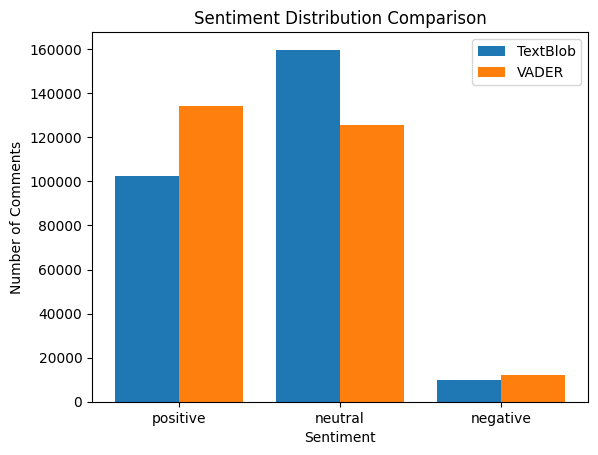

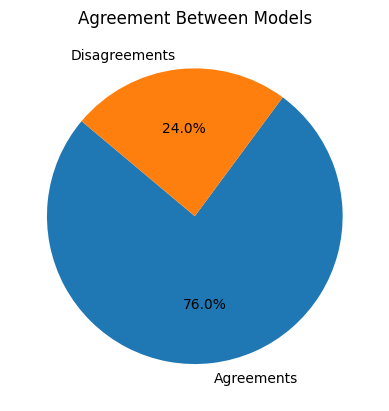

In [9]:
from pymongo import MongoClient
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import emoji
import re

# MongoDB Configuration
MONGO_URI = "mongodb://localhost:27017/"
client = MongoClient(MONGO_URI)
db = client["cr7_youtube_channel_data"]
english_comments_collection = db["cr7_english_comments_v3"]
sentiment_analysis_collection = db["cr7_sentiment_analysis_results_v4"]

# Initialize VADER analyzer
vader_analyzer = SentimentIntensityAnalyzer()

def preprocess_comment(comment):
    """
    Preprocess the comment by normalizing and removing noise.
    - Converts emojis to text
    - Removes URLs, mentions, and hashtags
    - Converts to lowercase and strips extra whitespace
    """
    comment = emoji.demojize(comment)  # Convert emojis to text
    comment = re.sub(r"http\S+", "", comment)  # Remove URLs
    comment = re.sub(r"@\w+", "", comment)  # Remove mentions
    comment = re.sub(r"#\w+", "", comment)  # Remove hashtags
    comment = comment.lower().strip()  # Normalize text
    return comment

def analyze_sentiment_textblob(comment):
    """Analyze sentiment using TextBlob."""
    blob = TextBlob(comment)
    polarity = blob.polarity
    sentiment = "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"
    return sentiment

def analyze_sentiment_vader(comment):
    """Analyze sentiment using VADER."""
    scores = vader_analyzer.polarity_scores(comment)
    compound_score = scores['compound']
    sentiment = "positive" if compound_score > 0.05 else "negative" if compound_score < -0.05 else "neutral"
    return sentiment

def run_sentiment_analysis():
    """Retrieve comments, preprocess, run sentiment analysis, and compare models."""
    cursor = english_comments_collection.find({}, {"_id": 0, "comment": 1})
    
    textblob_results = []
    vader_results = []

    for comment_doc in tqdm(cursor, desc="Analyzing Sentiment"):
        try:
            comment_text = comment_doc['comment']
            
            # Preprocess the comment
            preprocessed_comment = preprocess_comment(comment_text)
            
            # Analyze with both models
            tb_sentiment = analyze_sentiment_textblob(preprocessed_comment)
            vader_sentiment = analyze_sentiment_vader(preprocessed_comment)
            
            # Store results
            textblob_results.append(tb_sentiment)
            vader_results.append(vader_sentiment)
            
            # Save to MongoDB for future analysis
            result = {
                "comment": comment_text,
                "preprocessed_comment": preprocessed_comment,
                "textblob_sentiment": tb_sentiment,
                "vader_sentiment": vader_sentiment,
            }
            sentiment_analysis_collection.insert_one(result)

        except Exception as e:
            continue

    # Compare and analyze results
    compare_model_results(textblob_results, vader_results)

def compare_model_results(tb_results, vader_results):
    """Compare the sentiment distributions and agreements of both models."""
    # Count sentiment distributions
    tb_counts = Counter(tb_results)
    vader_counts = Counter(vader_results)
    
    # Count agreements and disagreements
    agreements = sum(1 for tb, vader in zip(tb_results, vader_results) if tb == vader)
    disagreements = len(tb_results) - agreements

    print(f"TextBlob Sentiment Distribution: {tb_counts}")
    print(f"VADER Sentiment Distribution: {vader_counts}")
    print(f"Agreements: {agreements}, Disagreements: {disagreements}")

    # Visualize distributions
    visualize_sentiment_distributions(tb_counts, vader_counts)
    visualize_agreement(agreements, disagreements)

def visualize_sentiment_distributions(tb_counts, vader_counts):
    """Visualize sentiment distributions of both models."""
    labels = ['positive', 'neutral', 'negative']
    tb_values = [tb_counts[label] for label in labels]
    vader_values = [vader_counts[label] for label in labels]

    # Plot side-by-side bar chart
    x = range(len(labels))
    plt.bar(x, tb_values, width=0.4, label='TextBlob', align='center')
    plt.bar([p + 0.4 for p in x], vader_values, width=0.4, label='VADER', align='center')
    plt.xticks([p + 0.2 for p in x], labels)
    plt.title("Sentiment Distribution Comparison")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Comments")
    plt.legend()
    plt.show()

def visualize_agreement(agreements, disagreements):
    """Visualize agreement and disagreement between models."""
    labels = ['Agreements', 'Disagreements']
    values = [agreements, disagreements]
    
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Agreement Between Models")
    plt.show()

if __name__ == "__main__":
    run_sentiment_analysis()
